In [2]:
import numpy as np
import gym
from tensorboardX import SummaryWriter

import time
from collections import namedtuple
from collections import deque
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gym import Env
from gym.spaces import Discrete, Box

import random

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops


In [3]:
class ConvOptEnv():
    def __init__(self):
        # 
        self.action_space =  Discrete(2)
        # Temperature array
        self.observation_space = Box(low=np.array([-np.inf]), high=np.array([np.inf]), dtype = np.float32)
        # Set sampled coefficients
        self.state = None
        self.state_var_1 , self.state_var_2 = random.randint(0,10),random.randint(0,10)
        self.state_var_3,self.state_var_4,self.state_var_5 = 0,0,0
        self.state = [self.state_var_1,self.state_var_2,0,0,0]
        self.x = random.randint(-100,100)
        self.y = random.randint(-100,100)
        self.z =(self.state_var_1*(self.x*self.x)) + (self.state_var_2*(self.y*self.y))
        self.agent = [self.x,self.y]
        self.minima = [0,0]
        self.distance = np.sqrt(((self.agent[0] - self.minima[0])**2)+((self.agent[1] - self.minima[1])**2))
        
        self.steps = 0
        self.distance = np.inf
        
    def step(self, action):
        
        self.steps = self.steps +1
        
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg
        state = np.array(self.state)
        self.x += state[0]
        self.y += state[1]
        self.z = (self.state_var_1*(self.x*self.x)) + (self.state_var_2*(self.y*self.y))
        
        # Calculate reward
        distance_new = np.sqrt(((self.x - self.minima[0])**2)+((self.y - self.minima[1])**2))
        reward = 0
        if self.z < self.z_prev :
            reward  = (self.z_prev - self.z)
        self.z_prev = self.z  
        # Apply temperature noise
        # Set placeholder for info
        info = {self.x ,self.y ,self.state_var_1,self.state_var_2,self.state_var_3,self.state_var_4,self.state_var_5}
        
        self.state = (self.x, self.y)
        done = False
        if (self.steps == 500) or (distance_new == 0):
            done = True
        self.state = [self.x,self.y,self.z]
        #reward = 1/(np.sqrt((self.agent[0]**2)+ (self.agent[0]**2)))
        # Return step information
        return np.array([self.z], dtype = np.float32), reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        self.state_var_1 , self.state_var_2 = random.randint(0,10),random.randint(0,10)
        self.state_var_3,self.state_var_4,self.state_var_5 = 0,0,0
        self.state = [self.state_var_1,self.state_var_2,0,0,0]
        self.x = random.randint(-100,100)
        self.y = random.randint(-100,100)
        self.z =(self.state_var_1*(self.x*self.x)) + (self.state_var_2*(self.y*self.y))
        self.agent = [self.x,self.y]
        self.minima = [0,0]
        self.distance = np.sqrt(((self.agent[0] - self.minima[0])**2)+((self.agent[1] - self.minima[1])**2))
        
        self.z_prev = self.z
        self.steps = 0

In [4]:
env = ConvOptEnv()

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

<ipython-input-3-a08097397c11>:31: RuntimeWarning: overflow encountered in long_scalars
  self.z = (self.state_var_1*(self.x*self.x)) + (self.state_var_2*(self.y*self.y))
<ipython-input-3-a08097397c11>:34: RuntimeWarning: invalid value encountered in sqrt
  distance_new = np.sqrt(((self.x - self.minima[0])**2)+((self.y - self.minima[1])**2))
<ipython-input-3-a08097397c11>:34: RuntimeWarning: overflow encountered in long_scalars
  distance_new = np.sqrt(((self.x - self.minima[0])**2)+((self.y - self.minima[1])**2))
<ipython-input-3-a08097397c11>:37: RuntimeWarning: overflow encountered in long_scalars
  reward  = (self.z_prev - self.z)
<ipython-input-5-1abe8e8c27a4>:11: RuntimeWarning: overflow encountered in long_scalars
  score+=reward


Episode:1 Score:1443105324
Episode:2 Score:-2018230256
Episode:3 Score:-1148578696
Episode:4 Score:-1341361357
Episode:5 Score:79430928
Episode:6 Score:-1839199955
Episode:7 Score:-1952254472
Episode:8 Score:-1342173344
Episode:9 Score:-1265302355
Episode:10 Score:-1321729056


In [6]:
class PG_nn(nn.Module):
      def __init__(self, input_shape, n_actions):
        super(PG_nn, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, n_actions))

    def forward(self, x):
        return self.mlp(x.float())

In [7]:
def discounted_rewards(memories, gamma):
     disc_rew = np.zeros(len(memories))
    run_add = 0

    for t in reversed(range(len(memories))):
        if memories[t].done: run_add = 0
        run_add = run_add * gamma + memories[t].reward
        disc_rew[t] = run_add

    return disc_rew

In [8]:
env.observation_space.sample()

array([-1.8338774], dtype=float32)

In [9]:
obs = env.observation_space.sample()

In [10]:
Memory = namedtuple('Memory', ['obs', 'action', 'new_obs', 'reward', 'done'], rename=False)

GAMMA = 0.99
LEARNING_RATE = 0.002
ENTROPY_BETA = 0.01

max_iterations = 200
iter_no = 0

device = 'cpu'

now = datetime.datetime.now()
date_time = "{}_{}.{}.{}".format(now.day, now.hour, now.minute, now.second)

In [12]:
env = ConvOptEnv()
obs = env.reset()

# Initialize the writer
writer = SummaryWriter(log_dir='content/runs/Conv_OPT'+date_time)

# create the agent neural net
action_n = env.action_space.n
agent_nn = PG_nn(env.observation_space.shape, action_n).to(device)

# Adam optimizer
optimizer = optim.Adam(agent_nn.parameters(), lr=LEARNING_RATE)

experience = []
tot_reward = 0
n_iter = 0
# deque list to keep the baseline
baseline = deque(maxlen=5000)
game_rew = 0
l1 = []
obs = env.observation_space.sample() 
## MAIN BODY
while iter_no < max_iterations:
    n_iter += 1
    
    # execute the agent
    act = agent_nn(torch.tensor(obs))
    act_soft = F.softmax(act)
    # get an action following the policy distribution
    action = int(np.random.choice(np.arange(action_n), p=act_soft.detach().numpy(), size=1))

    # make a step in the env
    new_obs, reward, done, info = env.step(action)

    game_rew += reward
    # update the experience list with the last memory
    experience.append(Memory(obs=obs, action=action, new_obs=new_obs, reward=reward, done=done))

    obs = new_obs

    if done:
        # Calculate the discounted rewards
        disc_rewards = discounted_rewards(experience, GAMMA)

        # update the baseline
        baseline.extend(disc_rewards)
        # subtract the baseline mean from the discounted reward.
        disc_rewards -= np.mean(baseline)

        # run the agent NN on the obs in the experience list
        acts = agent_nn(torch.tensor([e.obs for e in experience]))

        # take the log softmax of the action taken previously
        game_act_log_softmax_t = F.log_softmax(acts, dim=1)[:,[e.action for e in experience]]

        disc_rewards_t = torch.tensor(disc_rewards, dtype=torch.float32).to(device)

        # compute the loss entropy
        l_entropy = ENTROPY_BETA * torch.mean(torch.sum(F.softmax(acts, dim=1) * F.log_softmax(acts, dim=1), dim=1))

        # compute the loss
        loss = - torch.mean(disc_rewards_t * game_act_log_softmax_t)
        loss = loss + l_entropy

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the stats
        writer.add_scalar('loss', loss, n_iter)
        writer.add_scalar('reward', game_rew, n_iter)
        
        l1.append(experience)
    
        print(iter_no, loss.detach().numpy(), game_rew, np.mean(disc_rewards), np.mean(baseline))

        # reset the variables and env
        experience = []
        game_rew = 0
        obs = env.reset()
        iter_no += 1
        obs = new_obs
        
        
        done = False
        

writer.close()

<ipython-input-12-1efa65e171ad>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  act_soft = F.softmax(act)
<ipython-input-3-a08097397c11>:31: RuntimeWarning: overflow encountered in long_scalars
  self.z = (self.state_var_1*(self.x*self.x)) + (self.state_var_2*(self.y*self.y))
<ipython-input-3-a08097397c11>:34: RuntimeWarning: overflow encountered in long_scalars
  distance_new = np.sqrt(((self.x - self.minima[0])**2)+((self.y - self.minima[1])**2))
<ipython-input-3-a08097397c11>:34: RuntimeWarning: invalid value encountered in sqrt
  distance_new = np.sqrt(((self.x - self.minima[0])**2)+((self.y - self.minima[1])**2))
<ipython-input-3-a08097397c11>:37: RuntimeWarning: overflow encountered in long_scalars
  reward  = (self.z_prev - self.z)


0 -7298418000000000.0 36957217 3.856771132525276e-08 471552042.8244775
1 3295134300000000.0 423103944 -261829323.34455776 225124444.3825408
2 -2.6745612e+16 -2000551936 -901737123.9238572 -239406801.2752038
3 -1.25832e+16 1082140160 -1215411062.5551245 -652646562.5439463
4 2.1389395e+16 739446001 917798065.5547098 -419772426.5076764
5 -56676780.0 -1126452889 -2585509012.484286 -943030202.8437821
6 839173.56 -1983053824 38396113.50395214 -936567490.6698495
7 4022335.0 -1582497792 184522453.3688993 -909983747.3878895
8 64427480.0 -1311768576 2962757279.6883473 -536895793.6493566
9 -2.2791244e+16 1870659584 -974932029.5207684 -626692164.7894275
10 3884935000000000.0 586429169 3327922199.5843754 -285880855.1934373
11 59502576.0 -516890719 2839786144.869853 -22075584.90498108
12 -3.4799713e+16 -1625290311 -914233446.5423446 -95214260.62836851
13 7753317.0 -338221397 386048696.63588 -64830798.39313726
14 167789390.0 443809792 2853997284.091831 143400763.10712507
15 5993980000000000.0 7384602

<ipython-input-12-1efa65e171ad>:35: RuntimeWarning: overflow encountered in long_scalars
  game_rew += reward


 6134565.0 730873856 347280843.911618 721571436.4996779
25 18918690.0 1799094272 1002418529.9807987 759849948.3843862
26 -17220980.0 -950793945 -964914059.8714174 722140663.2859629
27 -11143184.0 191856640 -621481315.2679704 698766366.0303093
28 12121206.0 -2115502080 316725763.70059645 709571509.3548497
29 -46047600.0 1950069984 -2547094440.07954 620291910.4242266
30 -704887.5 1737949184 -36538259.57735601 619127344.3819206
31 -47200916.0 1319895040 -2589334762.2720747 534149176.50812644
32 -7294197.5 313720832 -374932112.66114026 522936253.51265335
33 -4742233400000000.0 304091640 -412150244.74329853 510220184.2556005
34 4.9365263e+16 -1828290560 1104692334.3769026 543283159.0520924
35 1.0208882e+17 2025308160 3726157897.8358593 651564670.6131344
36 24602792.0 -859521024 1257959394.5256534 687088440.890437
37 8694431.0 1889140736 429205724.871146 698875997.1469951
38 -26644446.0 -961019904 -1274327935.1549478 664813772.4651804
39 2.242929e+16 -2085942499 393310459.32602525 675053095.

172 12273786.0 -1936457728 1589322091.5819051 536995068.2917554
173 1933875.9 1589314146 252935027.0084344 538485499.993365
174 -13733429.0 -1776609149 -1812675944.5125818 527866791.84149957
175 -10720900.0 -1752955296 -1426126005.9480152 519561159.05591667
176 -1.065381e+17 -1405222912 -1343382535.0402036 511782717.94703263
177 -160145.33 373620736 -21889917.196456544 511656700.81450987
178 8282948.0 -2043543552 1153372601.3978076 518258496.84944683
179 -11979196.0 -1476394208 -1696788196.1574645 508601516.8244461
180 -1.1471744e+17 -1427433637 -1496495859.6870642 500630833.1510131
181 -15389744.0 1956642862 -2277549261.3604255 487810191.6135537
182 -38116212.0 -1342176153 -1446703194.911527 479712083.50901115
183 16408507.0 -1132898048 2545888040.335283 493883693.4257432
184 10889027.0 -1361240561 1724095017.7024112 503427690.59309614
185 1599173.5 1285364291 257992823.5406672 504847987.87295085
186 6573327.0 1634205696 539333437.3489637 507800860.1547326
187 -29279720.0 1974632448 -

In [13]:
experience


[]

In [14]:
l2 = []
for i in l1:
    l2.append(i[-1])
    

In [16]:
l2

[Memory(obs=array([-1.0737418e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=0, done=True),
 Memory(obs=array([-2.1474836e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=0, done=True),
 Memory(obs=array([-2.1474836e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=0, done=True),
 Memory(obs=array([0.], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=0, done=True),
 Memory(obs=array([-1.0737418e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=0, done=True),
 Memory(obs=array([-2.1474836e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=0, done=True),
 Memory(obs=array([1.0737418e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=1073741824, done=True),
 Memory(obs=array([1.0737418e+09], dtype=float32), action=1, new_obs=array([0.], dtype=float32), reward=1073741824, done=True),
 Memory(obs=array([1.0737418e+09], d

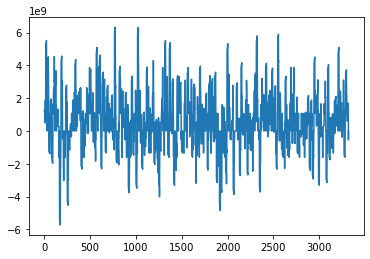

In [255]:
plt.plot(baseline)

In [17]:
l2 = []
for i in l1[0]:
    l2.append(i.new_obs)


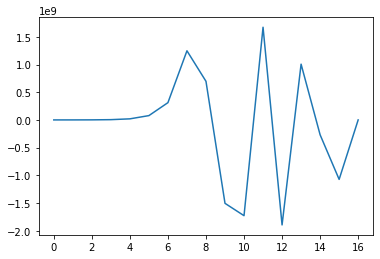

In [18]:
plt.plot(l2)

In [19]:
info

{0, 6, 7, 720896, 1638400}

In [20]:
l1[0]

[Memory(obs=array([1.5816096], dtype=float32), action=0, new_obs=array([76175.], dtype=float32), reward=11297, done=False),
 Memory(obs=array([76175.], dtype=float32), action=1, new_obs=array([304700.], dtype=float32), reward=0, done=False),
 Memory(obs=array([304700.], dtype=float32), action=1, new_obs=array([1218800.], dtype=float32), reward=0, done=False),
 Memory(obs=array([1218800.], dtype=float32), action=1, new_obs=array([4875200.], dtype=float32), reward=0, done=False),
 Memory(obs=array([4875200.], dtype=float32), action=1, new_obs=array([19500800.], dtype=float32), reward=0, done=False),
 Memory(obs=array([19500800.], dtype=float32), action=1, new_obs=array([78003200.], dtype=float32), reward=0, done=False),
 Memory(obs=array([78003200.], dtype=float32), action=1, new_obs=array([3.120128e+08], dtype=float32), reward=0, done=False),
 Memory(obs=array([3.120128e+08], dtype=float32), action=1, new_obs=array([1.2480512e+09], dtype=float32), reward=0, done=False),
 Memory(obs=arra